<a href="https://colab.research.google.com/github/belerico/unimib/blob/master/advanced%20machine%20learning/assignment%201/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U scipy
!pip install -U pandas_profiling
!pip install -U keras
!pip install -U keras_metrics

# Load dataset

In [0]:
import pandas as pd

dataset = pd.read_csv("https://raw.githubusercontent.com/belerico/unimib/master/advanced%20machine%20learning/assignment%201/data/train.csv")
testset = pd.read_csv("https://raw.githubusercontent.com/belerico/unimib/master/advanced%20machine%20learning/assignment%201/data/test.csv")
DATASET_SIZE = len(dataset)
N_TRAIN_DATA = int(DATASET_SIZE * 0.8)

# Data profiling

In [0]:
import pandas_profiling

trainset.profile_report(style={'full_width':True})

In [0]:
trainset.loc[trainset.iloc[:, -1] == 1].profile_report(style={'full_width':True})

## Remove duplicates

In [0]:
dataset = dataset.drop_duplicates()

# Dataset split

In [0]:
valset = dataset.iloc[N_TRAIN_DATA:]
trainset = dataset.iloc[:N_TRAIN_DATA]

# Correlation

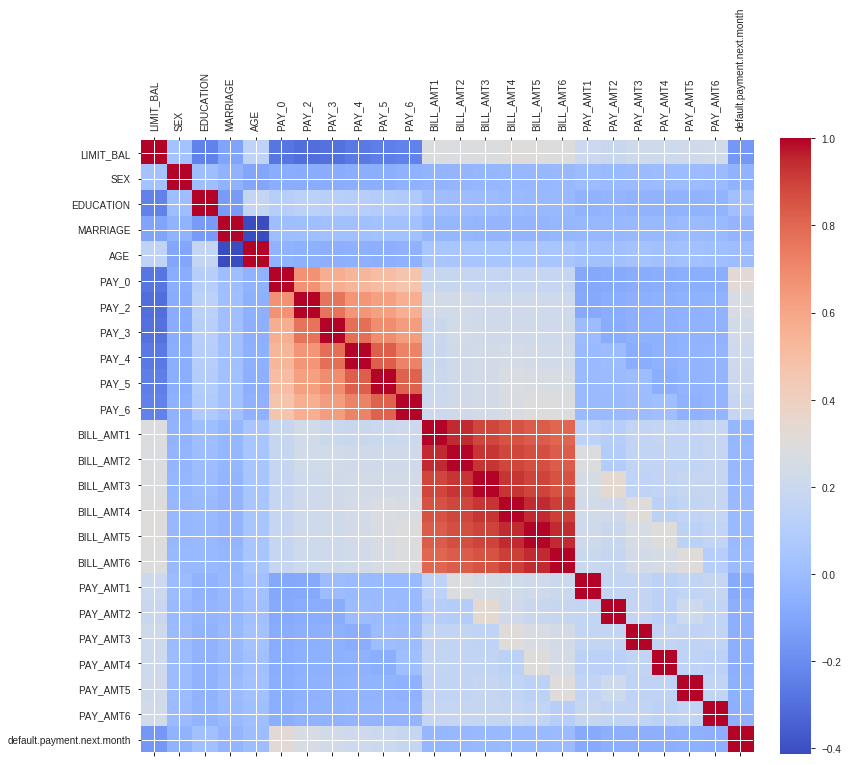

In [286]:
import matplotlib.pyplot as plt

correlation = trainset.corr()
f = plt.figure(figsize=(12, 12))
m = plt.matshow(correlation, fignum=f.number, cmap=plt.cm.coolwarm)
plt.xticks(range(trainset.shape[1]), trainset.columns, fontsize=10, rotation=90)
plt.yticks(range(trainset.shape[1]), trainset.columns, fontsize=10, rotation=0)
plt.colorbar(m, fraction=0.046, pad=0.04)
plt.show()

## Remove correlated attributes

In [287]:
import numpy as np

correlation = correlation.abs()
# Select upper triangle of correlation matrix
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
highly_correlated_attrs = [column for column in upper.columns if any(upper[column] > 0.90)]
trainset = trainset.drop(labels=highly_correlated_attrs, axis=1)
trainset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Sampling from distribution 

In [0]:
import math
import random

def discrete_sampling(n: int, pdf, values):
  assert(n > 0)
  assert(math.isclose(sum(pdf), 1))
  assert(len(pdf) == len(values))
  return __discrete_sampling(n, pdf, values)  
    
def __discrete_sampling(n: int, pdf, values):
  # Pair up probabilities and values
  pdf_values = list(zip(pdf, values))
  # Sort them 
  pdf_values.sort(reverse=True)
  # Compute the cumulative sum over pdfs
  # cdf_values = list(zip(list(accumulate([x[0] for x in pdf_values])), [x[1] for x in pdf_values]))
  cdf_values = [pdf_values[0]] + [(pdf_values[i][0] + pdf_values[i-1][0], pdf_values[i][1]) for i in range(1, len(pdf_values))]
  # sorted_indices = numpy.argsort(pdf)
  # cdf = numpy.cumsum([pdf[i] for i in reversed(sorted_indices)])
  # cdf_values = list(zip(cdf, [values[i] for i in reversed(sorted_indices)]))
  sample = [0] * n
  for i in range(0, n):
      for p, value in cdf_values:
          rand = random.random()
          if (rand <= p):
              sample[i] = value
              break
  return sample 

## Compute distributions per column, where the label is equal to 1

Such as an naive bayes approach, we consider the remaining columns `conditionally independent`.
Therefore we can estimate the probabilistic density function for each random variable from Ptrain(X)

In [0]:
trainset_class_1 = trainset[trainset.iloc[:, -1] == 1]
pdfs = []
values = []
# Compute all attributes pdfs
for col in trainset.columns:
  counts = trainset_class_1.loc[:, col].value_counts(normalize=True)
  pdfs.append(counts.values.tolist())
  values.append(counts.index.tolist())

## Hashing dataset values

In [0]:
unique_values = {}
for row in trainset.iloc[:, :-1].values:
  unique_values[str(row)] = 1
  additional_values_class_1.append(row)


## Sampling values from distribution for any attribute
We use the previously calculated pdfs to oversample the trainset for labels = 1

In [0]:
oversampled_trainset = trainset.copy(deep=True)
for _ in range(len(trainset) - 2*len(trainset_class_1)):
  sample = [np.random.choice(values[i], 1, p=pdfs[i])[0] for i in range(len(trainset.columns) - 1)] + [1]
  while True:
    try:
      unique_values[str(sample)]
    except KeyError:
      unique_values[str(sample)] = 1
      additional_values_class_1.append(sample)
      break
additional_class_1 = pd.DataFrame(additional_values_class_1, columns=trainset.columns)

In [0]:
oversampled_trainset = trainset.append(additional_class_1, ignore_index=True)

# k-means SMOTE sampling

Essentially, for any feature point it takes the nearest neighbor point based on a previous clustering, it takes the difference between those two point and multiplies it by a random number between 0 and 1 (it's taking a point on the line connecting the points)

In [0]:
pip install -U imbalanced-learn

In [0]:
from imblearn.over_sampling import KMeansSMOTE

sm = KMeansSMOTE(sampling_strategy='minority', random_state=42, kmeans_estimator=20, cluster_balance_threshold=0.35)
x_oversampled, y_oversampled = sm.fit_resample(trainset.iloc[:, :-1].values, trainset.iloc[:, -1].values)
oversampled_trainset = pd.DataFrame(x_oversampled, columns=trainset.columns[:-1])
oversampled_trainset[trainset.columns[-1]] = y_oversampled

In [0]:
print(oversampled_trainset.duplicated(keep=False))

# Normalization

In [293]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
scaled_trainset = pd.DataFrame(scaler.fit_transform(oversampled_trainset.iloc[:, :-1]), columns=oversampled_trainset.columns[:-1])
scaled_trainset['default.payment.next.month'] = oversampled_trainset.loc[:, ['default.payment.next.month']]
print(scaled_trainset.head(10))

   LIMIT_BAL       SEX  ...  PAY_AMT6  default.payment.next.month
0  -1.087689  0.982328  ... -0.311919                         1.0
1  -0.233983  0.982328  ... -0.183900                         1.0
2  -0.490095  0.982328  ...  0.008129                         0.0
3  -0.831577  0.982328  ... -0.247909                         0.0
4  -0.831577 -1.017990  ... -0.268457                         0.0
5  -0.831577 -1.017990  ... -0.260711                         0.0
6   3.010100 -1.017990  ...  0.569493                         0.0
7  -0.404724  0.982328  ... -0.213216                         0.0
8  -0.063242  0.982328  ... -0.247909                         0.0
9  -1.087689 -1.017990  ... -0.311919                         0.0

[10 rows x 19 columns]


# Neural networks

In [294]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import keras_metrics

model = models.Sequential()
model.add(layers.Dense(32, input_shape=(scaled_trainset.shape[1]-1,), activation="relu", kernel_initializer = "he_normal"))
model.add(layers.Dense(64, activation="relu", kernel_initializer = "he_normal"))
model.add(layers.Dense(32, activation="relu", kernel_initializer = "he_normal"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizers.SGD(lr = 0.01, momentum=0.9, nesterov=True), loss="binary_crossentropy", metrics =["accuracy", keras_metrics.binary_precision(), keras_metrics.binary_recall(), keras_metrics.binary_f1_score()])
model.summary()


tracking <tf.Variable 'Variable_136:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_137:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_138:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_139:0' shape=() dtype=int32> fn
tracking <tf.Variable 'Variable_140:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_141:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_142:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_143:0' shape=() dtype=int32> fn
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 32)                608       
_________________________________________________________________
dense_64 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
___

In [0]:
X = scaled_trainset.iloc[:, :-1].values
Y = scaled_trainset.iloc[:, -1].values

In [295]:
print(len(scaled_trainset[scaled_trainset.iloc[:, -1] == 1]), len(scaled_trainset[scaled_trainset.iloc[:, -1] == 0]))

16771 16771


In [296]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(Y), Y)
print(class_weights)
model.fit(X, Y, epochs=20, class_weight=dict(enumerate(class_weights, start=0)))

[1. 1.]
Train on 42008 samples
Epoch 1/20
42008/42008 [==============================] - 7s 175us/sample - loss: 0.4272 - acc: 0.8225 - precision: 0.8392 - recall: 0.8013 - f1_score: 0.8135
Epoch 2/20
42008/42008 [==============================] - 7s 169us/sample - loss: 0.3765 - acc: 0.8445 - precision: 0.8698 - recall: 0.8120 - f1_score: 0.8351
Epoch 3/20
20416/42008 [=============>................] - ETA: 3s - loss: 0.3644 - acc: 0.8527 - precision: 0.8771 - recall: 0.8200 - f1_score: 0.8427

KeyboardInterrupt: ignored